# Density vs density-contrast

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt

PROJ: proj_create_from_database: Cannot find proj.db


Here we show that the calculated forward gravity of 2 sets of layers of absolute densities is identical to using the density contrasts across each surface.
<img src="../figures/absolute_vs_density_contrasts_2surfaces.svg" width="1000"/>

## Get sample data

Ice surface and bed from Bedmap2

c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


returning original grid
returning original grid


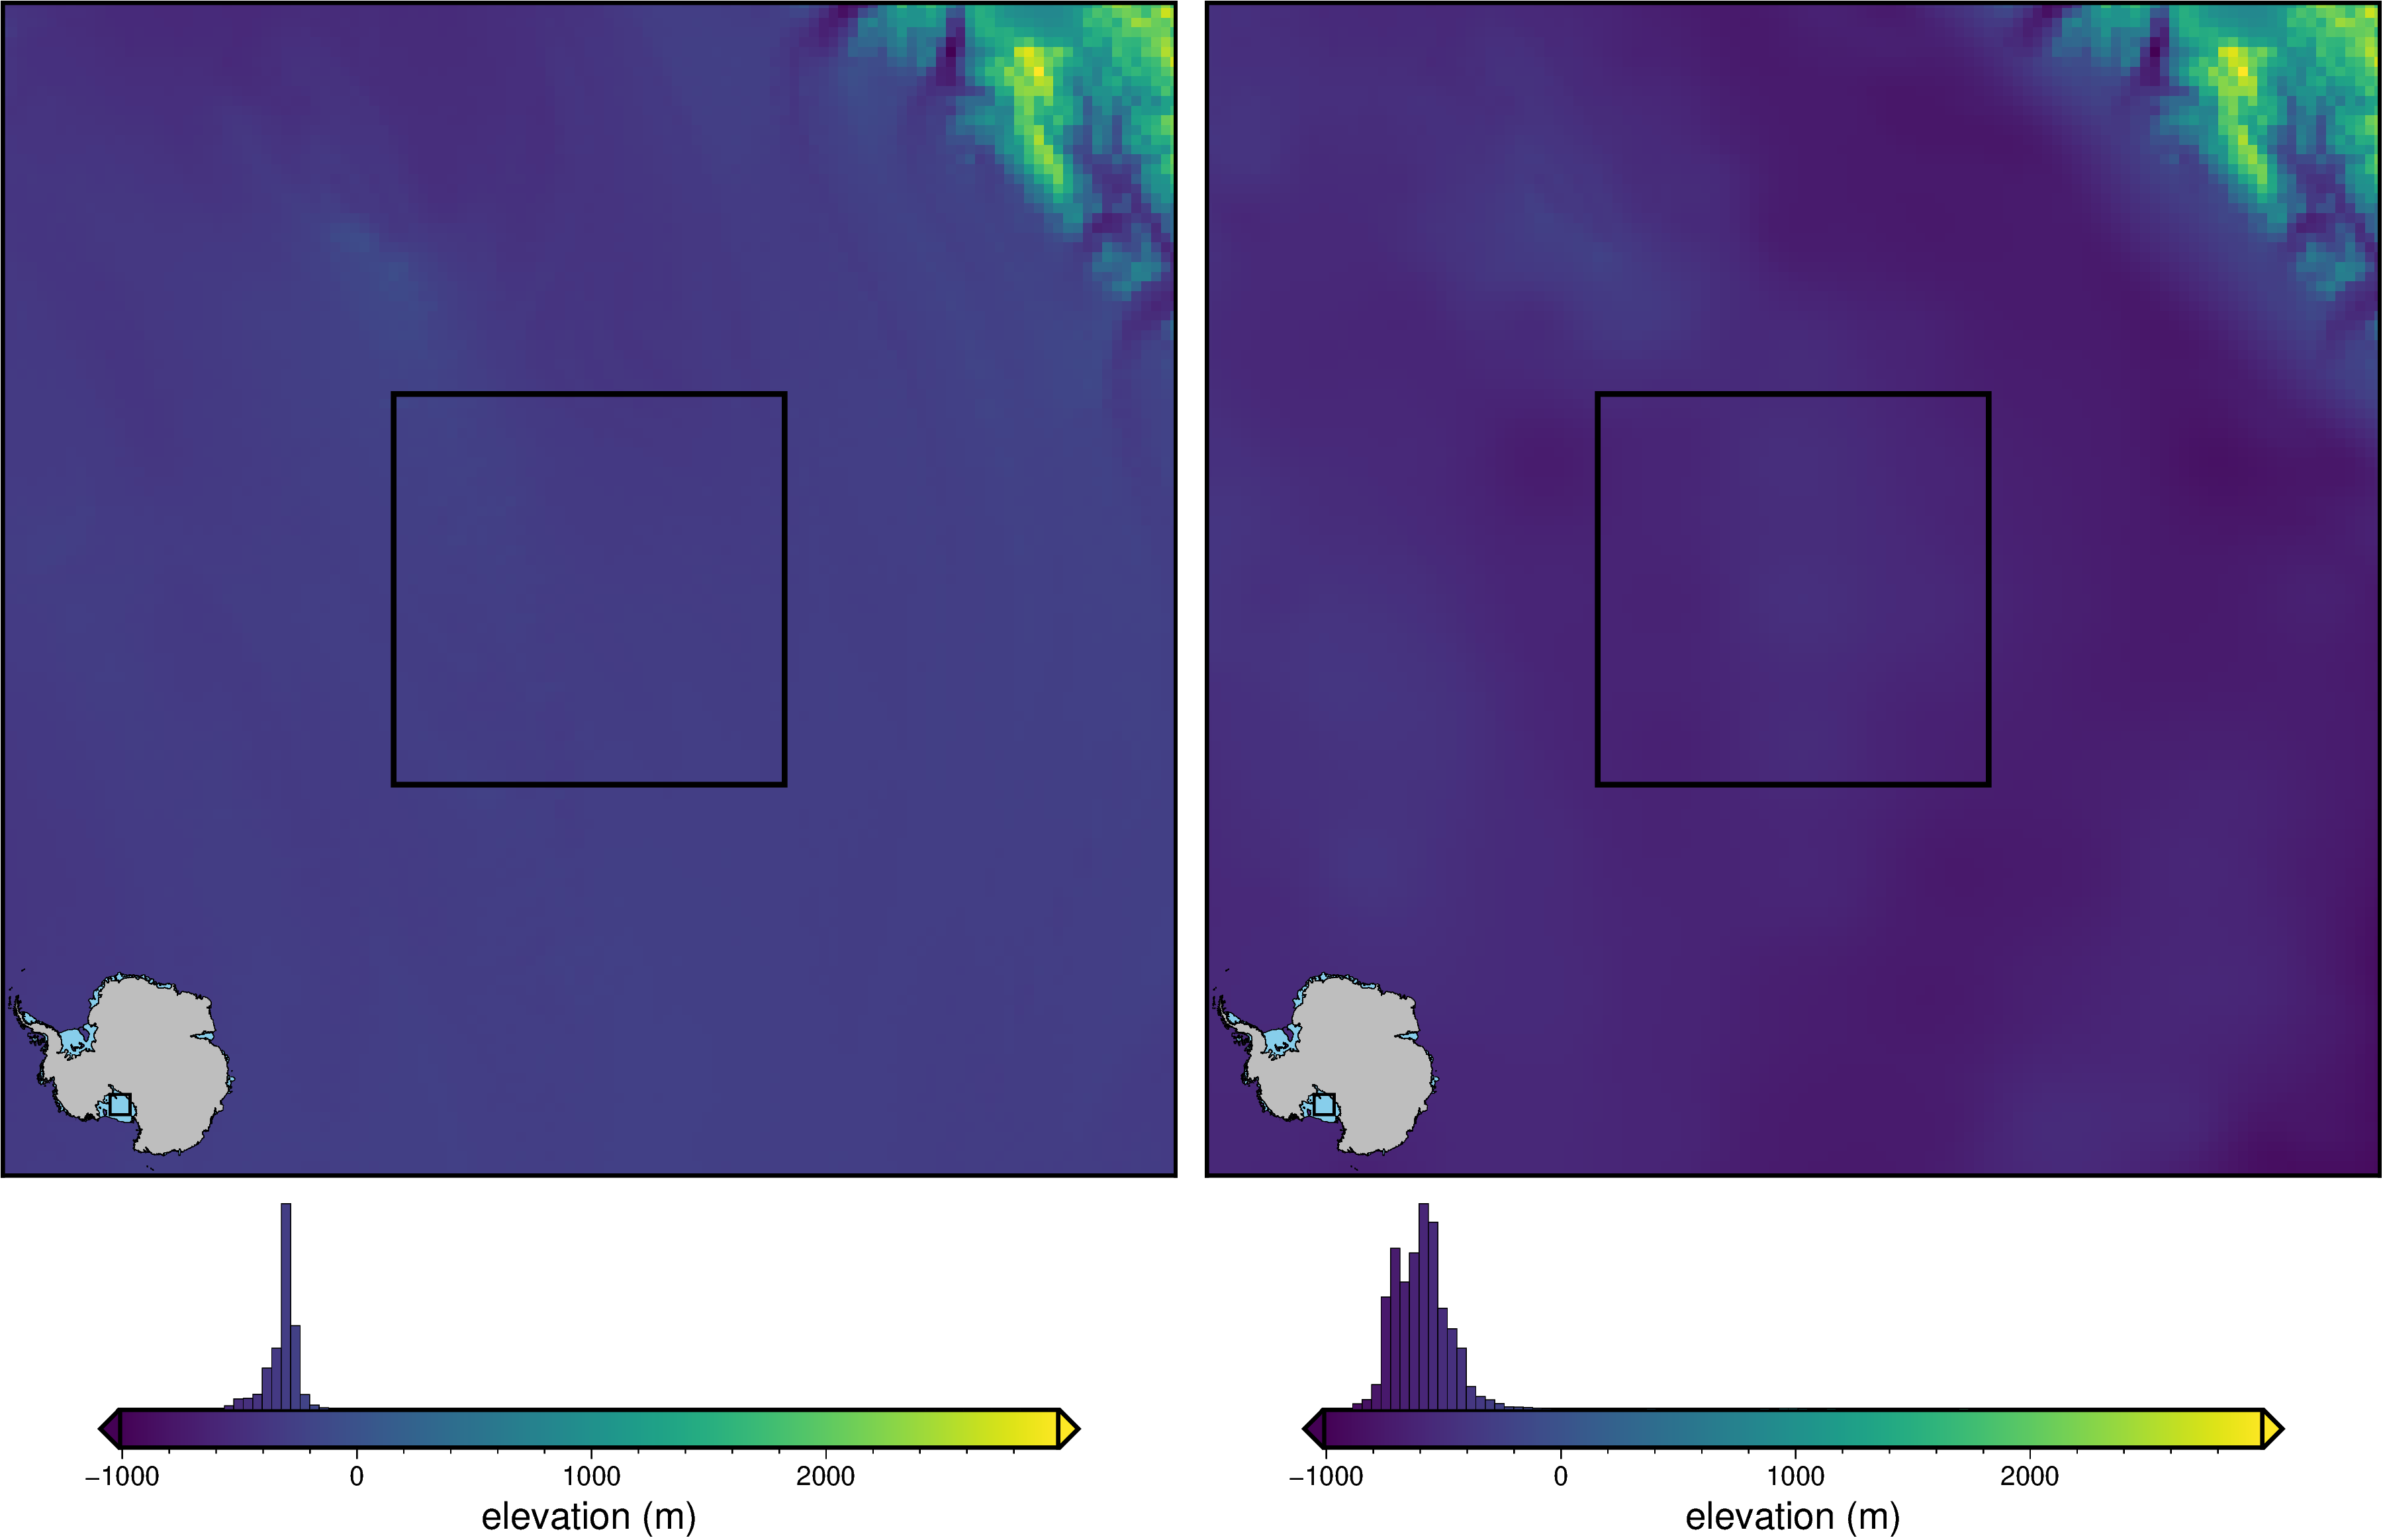

icebase info:  (4000.0, [-240000.0, 240000.0, -1160000.0, -680000.0], -1009.32537842, 2989.55688477, 'g')
bed info:  (4000.0, [-240000.0, 240000.0, -1160000.0, -680000.0], -1009.32537842, 2989.55688477, 'g')


In [2]:
spacing = 4e3

inner_region = [-80e3, 80e3, -1000e3, -840e3]

buffer_region = utils.alter_region(inner_region, buffer=160e3)[1]

icebase = fetch.bedmap2(layer="icebase", region=buffer_region, spacing=spacing)

bed = fetch.bedmap2(layer="bed", region=buffer_region, spacing=spacing)

fig = maps.plot_grd(
    icebase,
    inset=True,
    titles="Icebase",
    cbar_label="elevation (m)",
    show_region=inner_region,
    hist=True,
)

fig = maps.plot_grd(
    bed,
    inset=True,
    titles="Bed",
    cbar_label="elevation (m)",
    show_region=inner_region,
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.show()

print("icebase info: ", utils.get_grid_info(icebase))
print("bed info: ", utils.get_grid_info(bed))

## create observation points

In [3]:
coords = vd.grid_coordinates(
    inner_region,
    spacing=spacing * 2,
    extra_coords=3e3,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="z",
    dims=("y", "x"),
).z

observation_points = vd.grid_to_table(observations)

(8000.0, [-80000.0, 80000.0, -1000000.0, -840000.0], 3000.0, 3000.0, 'g')


## Absolute Densities

In [4]:
ice_prisms = inv_utils.grids_to_prisms(
    icebase,
    icebase.values.max(),
    density=917,
)

water_prisms = inv_utils.grids_to_prisms(
    icebase,
    bed,
    density=1030,
)

bed_prisms = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670,
)

plotting.show_prism_layers(
    [ice_prisms, water_prisms, bed_prisms],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    # color_by='constant',
    clip_box=False,
    zscale=20,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

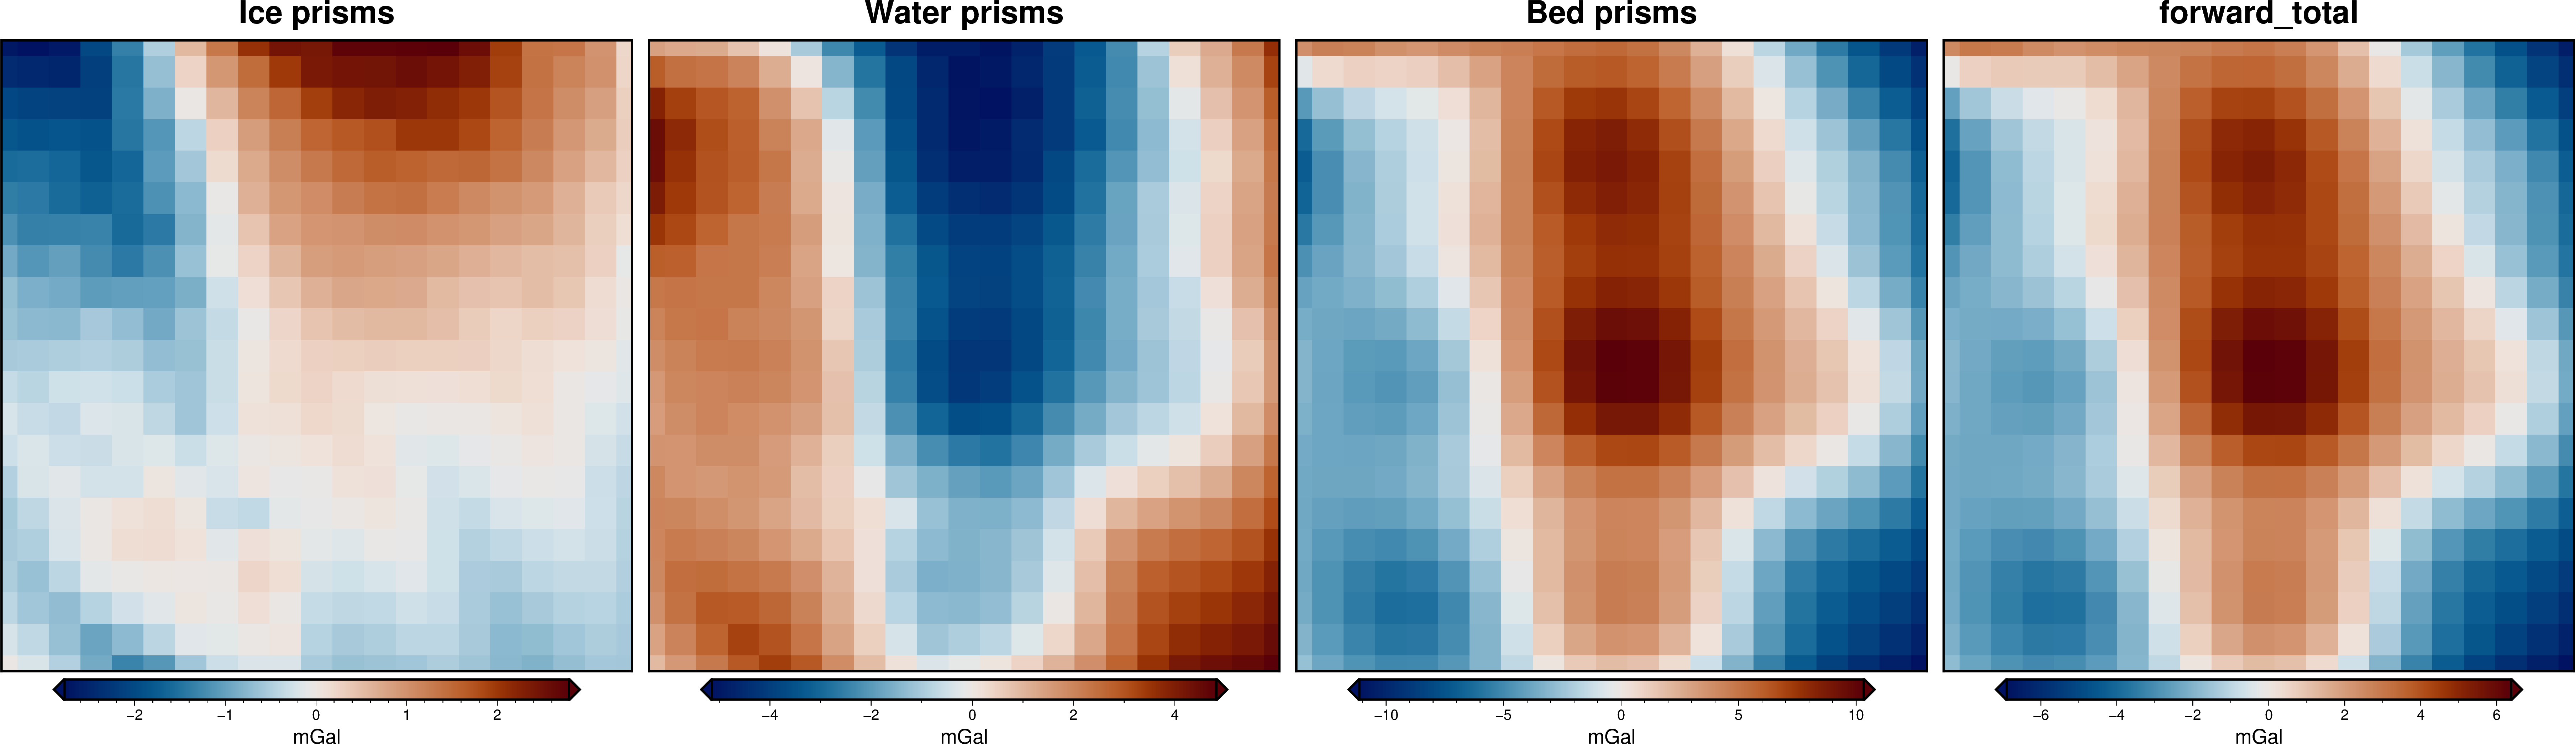

In [5]:
forward_absolute, df = inv_utils.forward_grav_of_prismlayer(
    [ice_prisms, water_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["Ice prisms", "Water prisms", "Bed prisms"],
    remove_mean=True,
    progressbar=True,
)

## Density contrasts

In [6]:
water_prisms_rel2ice = inv_utils.grids_to_prisms(
    icebase,
    bed,
    density=1030 - 917,
)

bed_prisms_rel2ice = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670 - 917,
)

plotting.show_prism_layers(
    [water_prisms_rel2ice, bed_prisms_rel2ice],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    # color_by='constant',
    clip_box=False,
    zscale=20,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

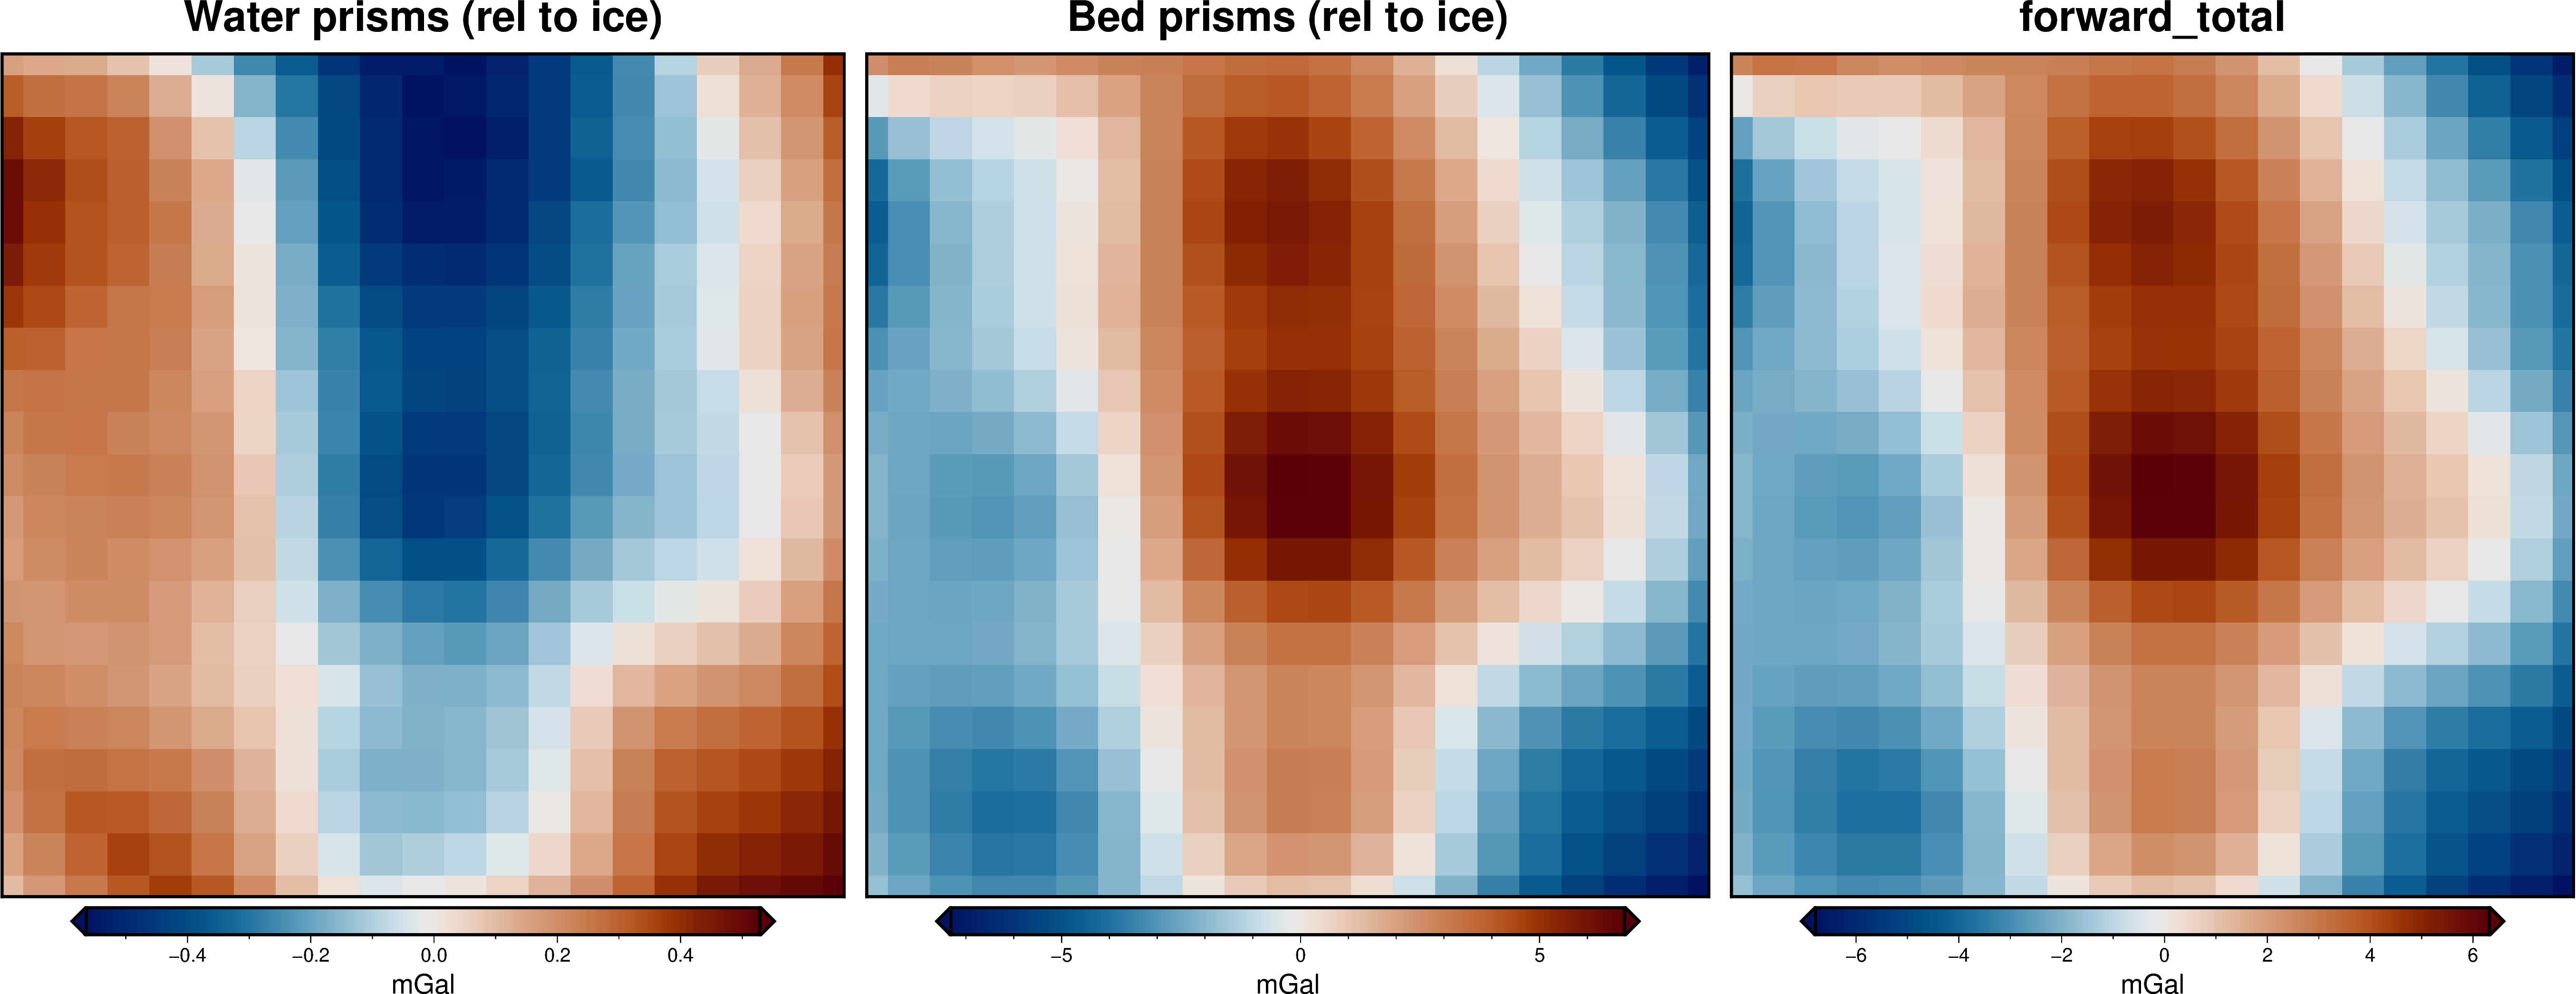

In [8]:
grav_rel2ice, df = inv_utils.forward_grav_of_prismlayer(
    [water_prisms_rel2ice, bed_prisms_rel2ice],
    observation_points,
    plot=True,
    names=["Water prisms (rel to ice)", "Bed prisms (rel to ice)"],
    remove_mean=True,
    progressbar=True,
)

In [9]:
ice_prisms_rel2water = inv_utils.grids_to_prisms(
    icebase,
    icebase.values.max(),
    density=917 - 1030,
)

bed_prisms_rel2water = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670 - 1030,
)

plotting.show_prism_layers(
    [ice_prisms_rel2water, bed_prisms_rel2water],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    # color_by='constant',
    clip_box=False,
    zscale=20,
)

ERROR:root:Bad table range: [2.22507e-308, -113]


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

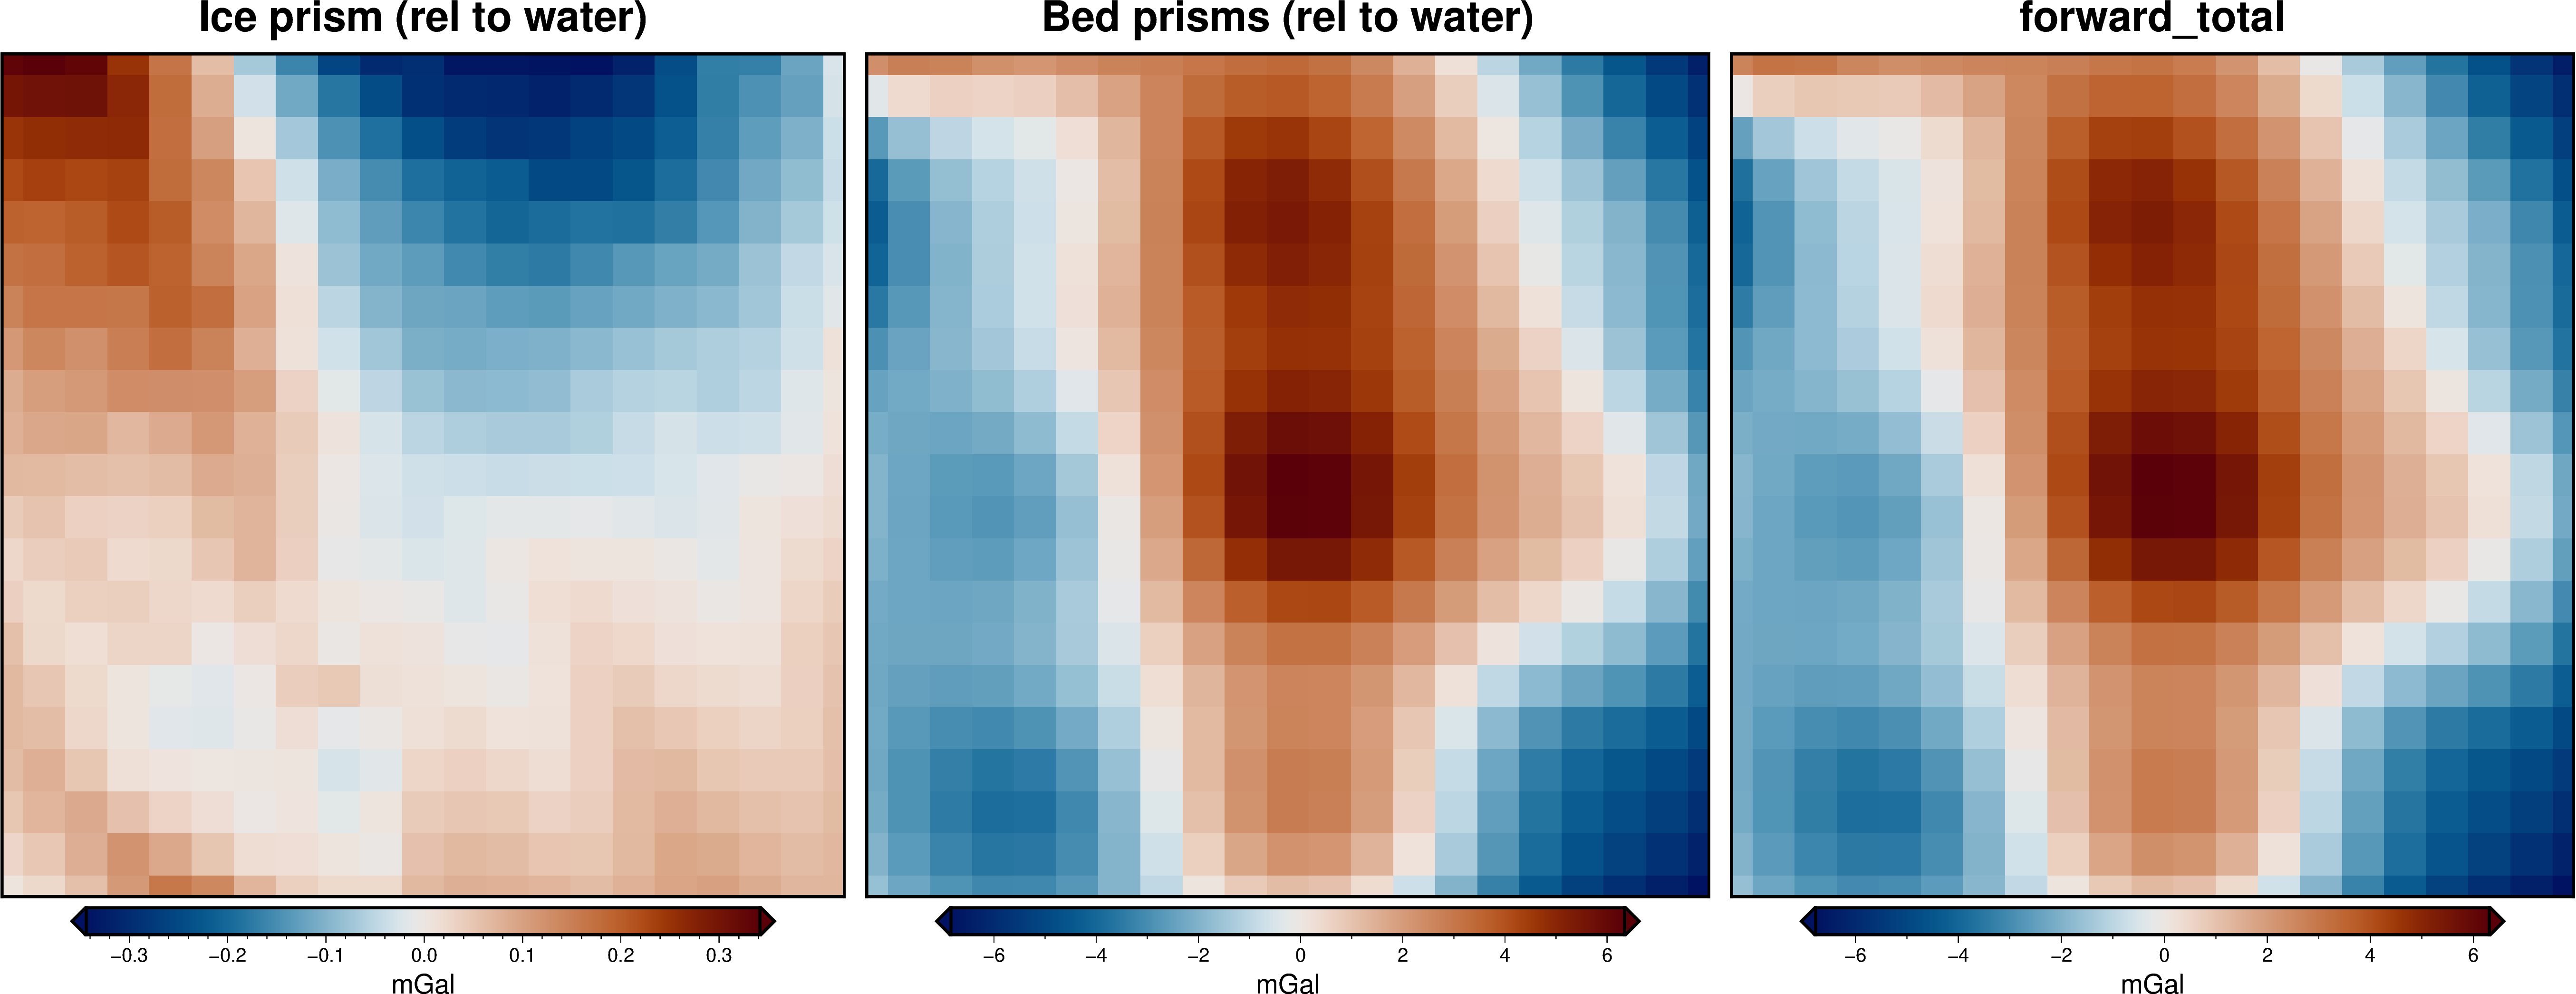

In [11]:
grav_rel2water, df = inv_utils.forward_grav_of_prismlayer(
    [ice_prisms_rel2water, bed_prisms_rel2water],
    observation_points,
    plot=True,
    names=["Ice prism (rel to water)", "Bed prisms (rel to water)"],
    remove_mean=True,
    progressbar=True,
)

In [12]:
ice_prisms_rel2bed = inv_utils.grids_to_prisms(
    icebase,
    icebase.values.max(),
    density=917 - 2670,
)

water_prisms_rel2bed = inv_utils.grids_to_prisms(
    icebase,
    bed,
    density=1030 - 2670,
)

plotting.show_prism_layers(
    [ice_prisms_rel2bed, water_prisms_rel2bed],
    cmap="viridis",
    # color_by="density",
    # color_by="thickness",
    color_by="constant",
    clip_box=False,
    zscale=20,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

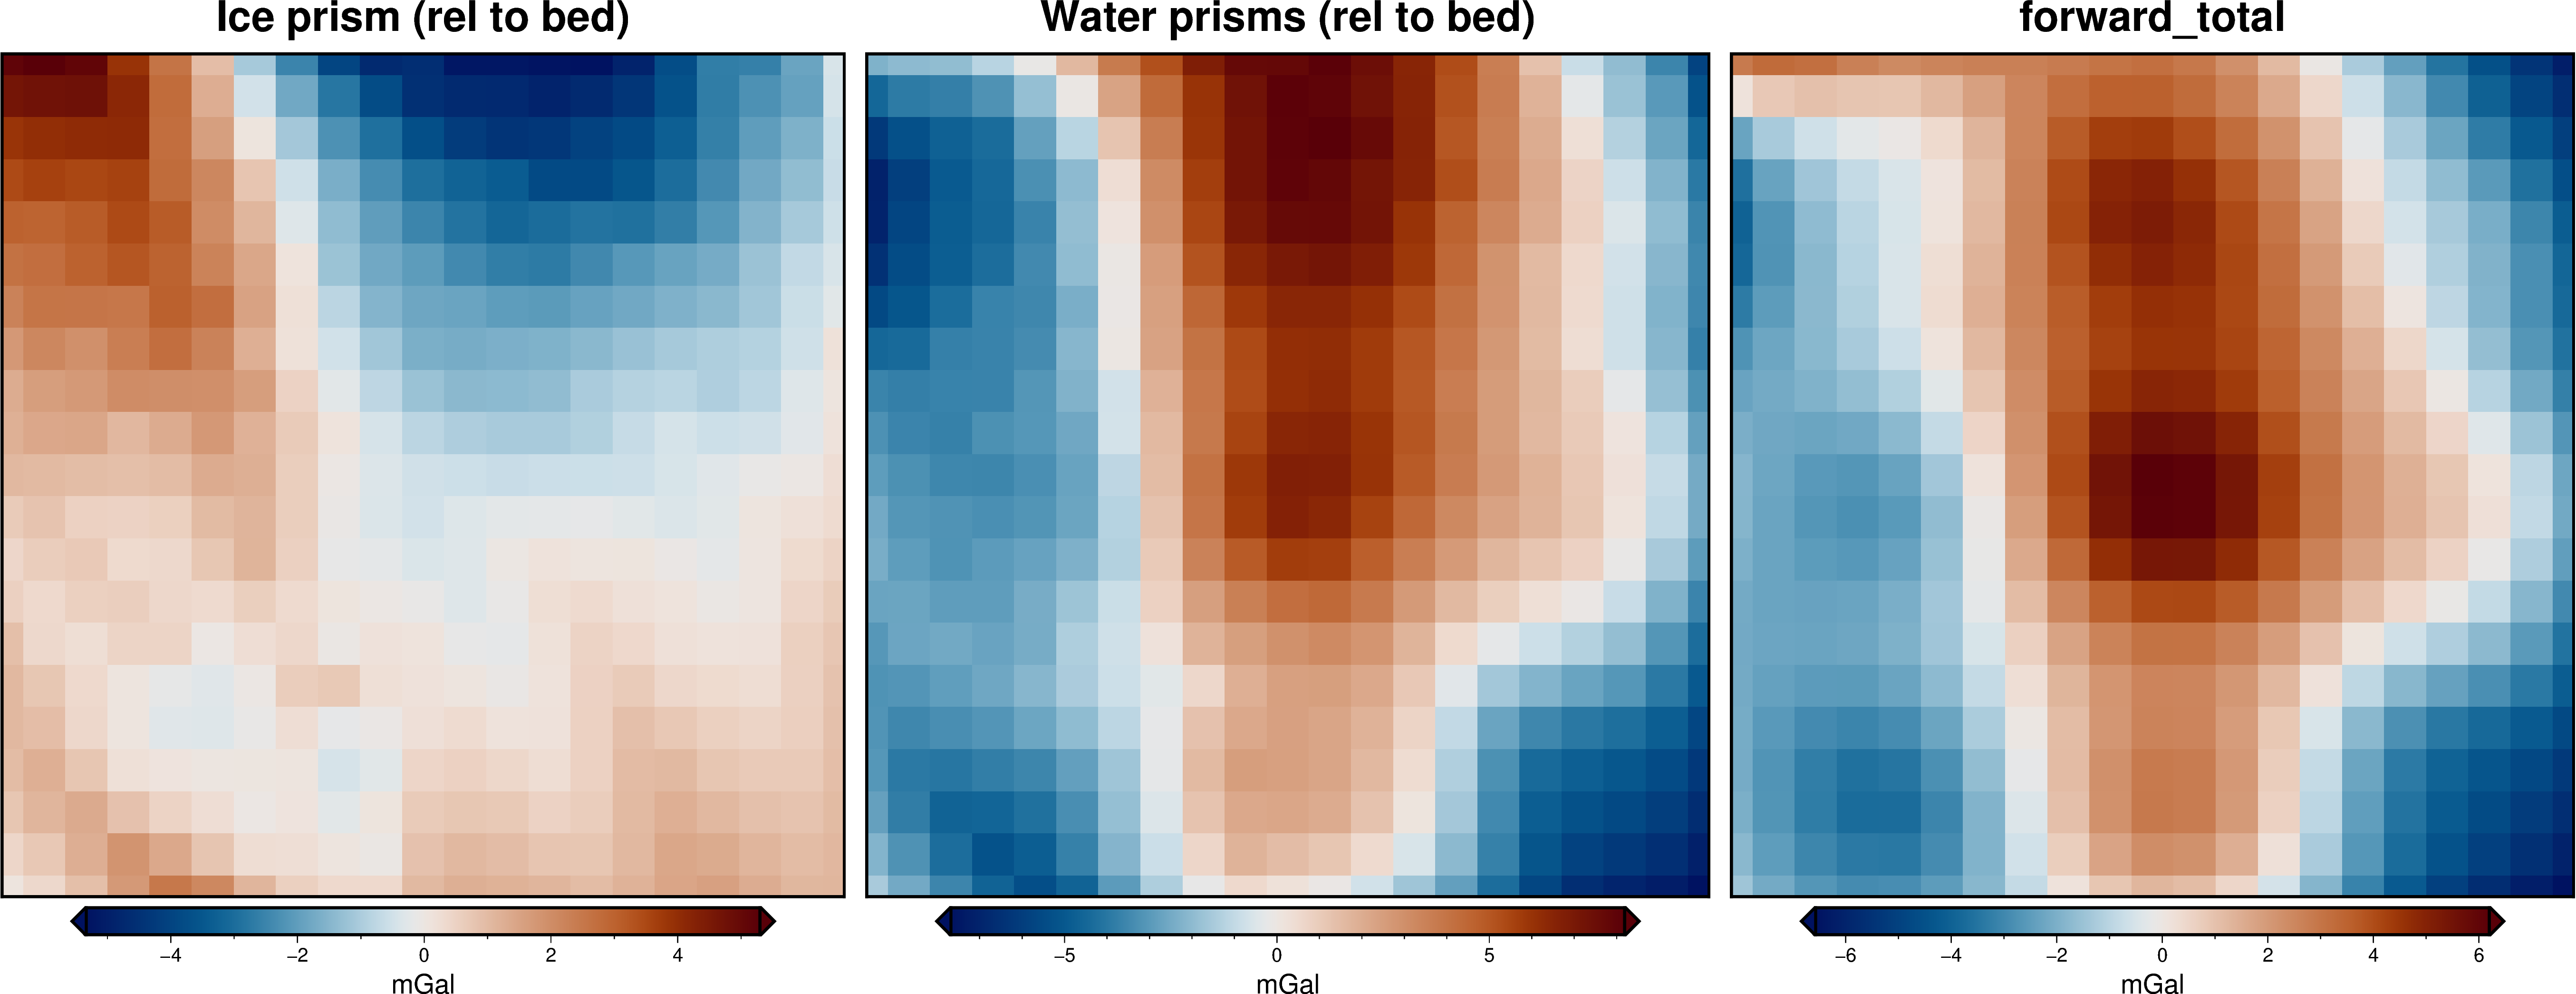

In [13]:
grav_rel2bed, df = inv_utils.forward_grav_of_prismlayer(
    [ice_prisms_rel2bed, water_prisms_rel2bed],
    observation_points,
    plot=True,
    names=["Ice prism (rel to bed)", "Water prisms (rel to bed)"],
    remove_mean=True,
    progressbar=True,
)

## Compare forward gravities

In [14]:
plot_type = "xarray"
# plot_type = 'pygmt'

returning original grid
returning original grid


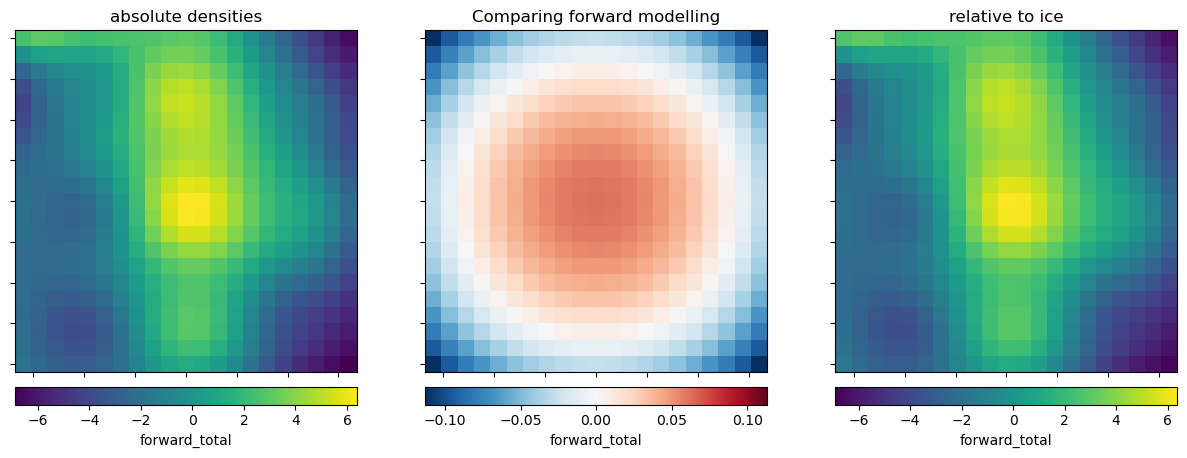

In [15]:
grids = utils.grd_compare(
    forward_absolute.forward_total,
    grav_rel2ice.forward_total,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="relative to ice",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)

returning original grid
returning original grid


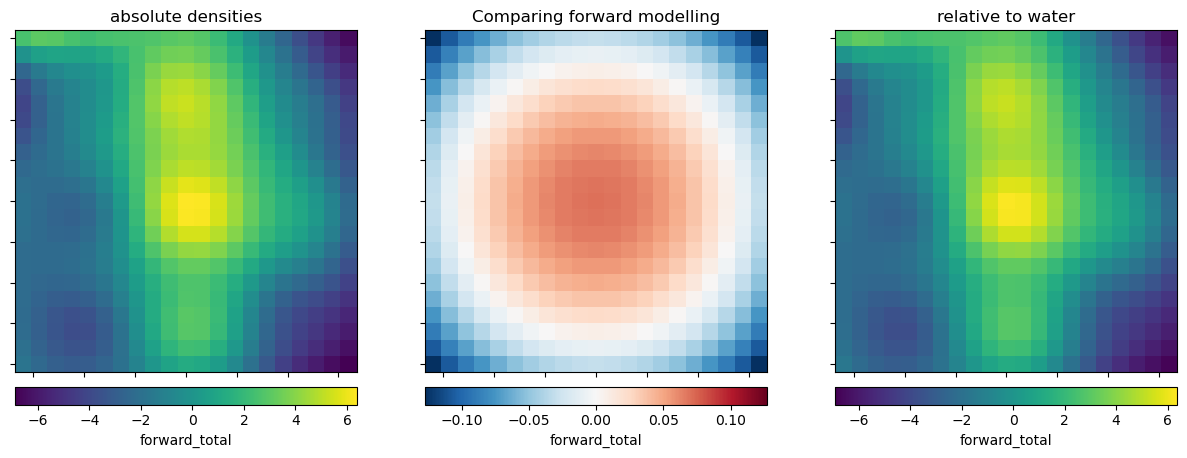

In [16]:
grids = utils.grd_compare(
    forward_absolute.forward_total,
    grav_rel2water.forward_total,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="relative to water",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)

returning original grid
returning original grid


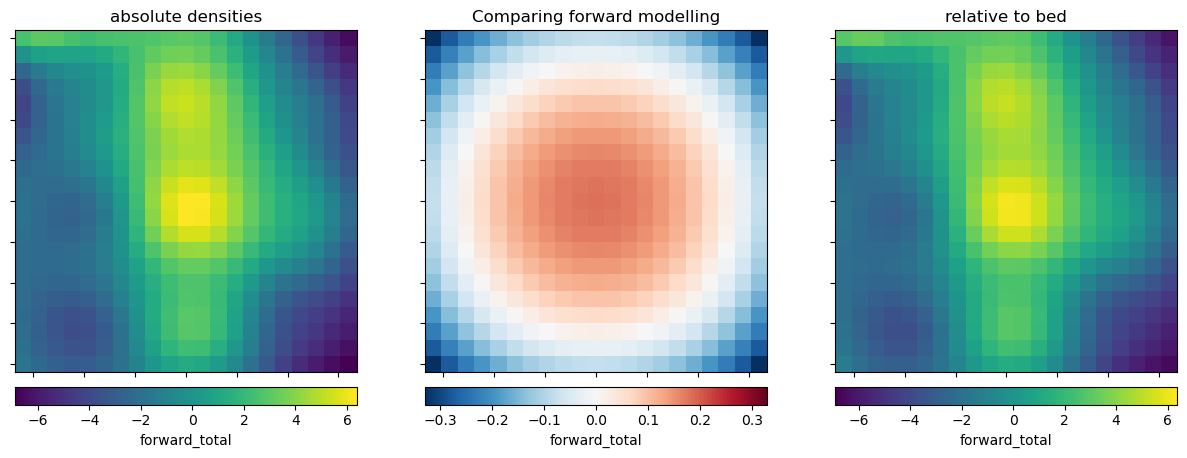

In [17]:
grids = utils.grd_compare(
    forward_absolute.forward_total,
    grav_rel2bed.forward_total,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="relative to bed",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)